Train models that have different dimensionality, infer embeddings, and then calculate test metrics. 

In [ ]:
import multiprocessing
import os
import pickle
import random

import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import model_selection
from scipy import stats
from sklearn import metrics

from gpmodel import gpmodel  # ?? What's this from?
from gpmodel import gpkernel
from gpmodel import gptools
from embeddings_reproduction import embedding_tools

In [ ]:
%matplotlib inline

In [ ]:
sns.set_style('white')
sns.set_context('paper')

In [ ]:
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'axes.labelsize': 25})
plt.rcParams.update({'legend.fontsize': 20})
plt.rcParams.update({'axes.titlesize': 25})

plt.rcParams.update({'axes.grid': False})

In [1]:
# assert gensim.__version__ == '1.0.1'
# assert np.__version__ == '1.13.1'
# assert pd.__version__ == '0.20.3'

In [2]:
sequence_dict = {}
sequence_dict['original'] = pd.read_csv('../inputs/uniprot-reviewed-lim_sequences.txt', comment='#')
sequence_dict['scrambled'] = pd.read_csv('../inputs/r1.txt')
sequence_dict['random'] = pd.read_csv('../inputs/r2.txt')
sequence_dict['uniform'] = pd.read_csv('../inputs/r3.txt')

In [5]:
tasks = ('log_GFP', 'peak', 'T50', 'e-value')
hypers = [('scrambled', 3, 5), ('uniform', 4, 1), ('original', 3, 7), ('random', 3, 7)]
dims = (4, 8, 16, 32, 96, 128)

In [6]:
def train(X, k, window, dim):
    name_list = [X, str(k), str(window), str(dim)]
    print('X\t\tk\twindow\tdim')
    print(name_list[0] + '\t' + '\t'.join(name_list[1:]))
    if os.path.isfile('../outputs/augmented_models/' + '_'.join(name_list) + '.pkl'):
        return
    kmer_hypers = {'k':k, 
                   'overlap':False,
                   'merge':False}
    model_hypers = {'size': dim,
                    'min_count': 0,
                    'iter': 25,
                    'window':window,
                    'workers': 2}
    documents = embedding_tools.Corpus(sequence_dict[X], kmer_hypers)
    model = Doc2Vec(**model_hypers)
    model.build_vocab(documents)
    %time model.train(documents)
    model.save('../outputs/augmented_models/' + '_'.join(name_list) + '.pkl')

In [7]:
for X, k, w in hypers:
    for dim in dims:
        train(X, k, w, dim)

X		k	window	dim
scrambled	3	5	4
X		k	window	dim
scrambled	3	5	8
X		k	window	dim
scrambled	3	5	16
X		k	window	dim
scrambled	3	5	32
X		k	window	dim
scrambled	3	5	96
X		k	window	dim
scrambled	3	5	128
X		k	window	dim
uniform	4	1	4
X		k	window	dim
uniform	4	1	8
X		k	window	dim
uniform	4	1	16
X		k	window	dim
uniform	4	1	32
X		k	window	dim
uniform	4	1	96
X		k	window	dim
uniform	4	1	128
X		k	window	dim
original	3	7	4
X		k	window	dim
original	3	7	8
X		k	window	dim
original	3	7	16
X		k	window	dim
original	3	7	32
X		k	window	dim
original	3	7	96
X		k	window	dim
original	3	7	128
X		k	window	dim
random	3	7	4
X		k	window	dim
random	3	7	8
X		k	window	dim
random	3	7	16
X		k	window	dim
random	3	7	32
X		k	window	dim
random	3	7	96
X		k	window	dim
random	3	7	128


In [8]:
models = os.listdir('../outputs/augmented_models/')
models = [m for m in models if m[-3:] == 'pkl']
models[0]

'random_3_7_16.pkl'

In [10]:
dfs = {}
dfs['log_GFP'] = pd.read_csv('../inputs/localization.txt')
dfs['peak'] = pd.read_csv('../inputs/absorption.txt')
dfs['T50'] = pd.read_csv('../inputs/T50.txt')
dfs['e-value'] = pd.read_csv('../inputs/enantioselectivity.txt')

dirs = {}
dirs['peak'] = '../outputs/absorption_d_embeddings/'
dirs['T50'] = '../outputs/T50_d_embeddings/'
dirs['e-value'] = '../outputs/enantioselectivity_d_embeddings/'
dirs['log_GFP'] = '../outputs/localization_d_embeddings/'


In [11]:
def infer_vectors(df, model, k, dest, overlap=False, method=None):       
    seqs = embedding_tools.get_seqs(df)
    if method is not None:
        seqs = embedding_tools.randomize_seqs(seqs, method=method)
    embeds = embedding_tools.get_embeddings_new(model, seqs, k=k,
                                                overlap=overlap)
    embeds = pd.DataFrame(embeds, index=df.name)
    terms = list(range(embeds.shape[1]))
    name = model.split('/')[-1]
    with open(dest + 'X_' + name, 'wb') as f:
        pickle.dump((embeds, terms), f)
        
        
for i, t in enumerate(tasks):
    Xs = os.listdir(dirs[t])
    name = '_'.join([str(h) for h in hypers[i]])
    for model in models:
        if name not in model:
            continue
        if 'X_' + model in Xs:
            continue
        print('Model ' + model + ' for dataset ' + t + ':')
        k = int(model.split('_')[1])
        print('Inferring...')
        %time infer_vectors(dfs[t], 'augmented_models/' + model, k, dirs[t])
        print('Success!')

In [12]:
def select_X_and_Y(df, all_X, y_column):
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped][y_column]
    Ys.index = df[not_dropped]['name']
    Xs = all_X.loc[Ys.index]
    return Xs, Ys

def score(Y, pred_Y, pred_var):
    r1 = stats.rankdata(Y)
    r2 = stats.rankdata(pred_Y)
    scores = {}
    scores['kendalltau'] = stats.kendalltau(r1, r2).correlation
    scores['R2'] = metrics.r2_score(Y, pred_Y)
    scores['mae'] = metrics.mean_absolute_error(Y, pred_Y)
    scores['SE'] = metrics.mean_squared_error(Y, pred_Y)
    scores['R'] = np.corrcoef(Y, pred_Y)[0, 1]
    log_ps = -0.5 * np.log(pred_var) - (pred_Y - Y)**2 / 2 / pred_var
    log_ps -= 0.5 * np.log(2 * np.pi)
    scores['log_loss'] = -np.sum(log_ps)
    return scores

def evaluate(df_train, df_test, X, task, X_name, guesses=None, kernel='matern'):
    X_train, y_train = select_X_and_Y(df_train, X, task)
    X_test, y_test = select_X_and_Y(df_test, X, task)
    n_train, d = X_train.shape
    n_test, d = X_test.shape
    if kernel == 'matern':
        k = gpkernel.MaternKernel('5/2')
    if kernel == 'cubic':
        k = gpkernel.PolynomialKernel(3)
    clf = gpmodel.GPRegressor(k, guesses=guesses)
    clf.fit(X_train, y_train)
    print(X_name)
    print(clf.hypers)
    mu, var = clf.predict(X_test)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = task
    met1['X'] = X_name
    met1['d'] = int((X_name.split('.')[0]).split('_')[-1])
    met1['n_train'] = n_train
    met1['n_test'] = n_test
    met1['kernel'] = kernel
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

In [13]:
fname = '../outputs/vary_d_test.txt'
res = pd.DataFrame(index=[])

for t in tasks:
    df = dfs[t]
    e_dir = dirs[t]
    df_test = df[~df.is_train]
    df_train = df[df.is_train]

    # Embedding
    Xs = os.listdir(e_dir)
    for emb in Xs:
        with open(e_dir + emb, 'rb')  as f:
            X = pickle.load(f)
        if len(X) == 2:
            X = X[0]
        evals, mu = evaluate(df_train, df_test, X, t, emb[:-4], guesses=(0.1, 10))
        res = pd.concat((res, evals), ignore_index=True)
res.head()

X_scrambled_3_5_96
[ 0.20754917  0.4062834 ]
X_scrambled_3_5_4
[ 0.96325305  0.767192  ]
X_scrambled_3_5_32
[ 0.23761522  0.33036566]
X_scrambled_3_5_128
[ 0.23953351  0.46379916]
X_scrambled_3_5_16
[ 0.41818287  0.30810748]
X_scrambled_3_5_8
[ 0.71485149  0.26678404]
X_scrambled_3_5_64
[ 0.25197468  0.43406704]
X_uniform_4_1_96
[  1.00000000e-05   2.42071518e-01]
X_uniform_4_1_32
[ 0.11783373  0.22176597]
X_uniform_4_1_128
[  1.00000000e-05   2.57346458e-01]
X_uniform_4_1_4
[ 1.01586857  9.99994807]
X_uniform_4_1_8
[ 0.75082606  0.41054936]
X_uniform_4_1_16
[ 0.30881944  0.22697701]
X_uniform_4_1_64
[  1.00000000e-05   2.61140443e-01]
X_original_3_7_8
[ 0.27598078  0.23024228]
X_original_3_7_96
[ 0.04922276  0.73638549]
X_original_3_7_32
[ 0.06673573  0.5836309 ]
X_original_3_7_128
[ 0.03868637  0.70553586]
X_original_3_7_16
[ 0.11102507  0.40362374]
X_original_3_7_64
[ 0.04603909  0.7119394 ]
X_original_3_7_4
[ 0.86475992  0.34434363]
X_random_3_7_96
[  1.00000000e-05   2.60119096e-0

,R,R2,SE,X,d,kendalltau,kernel,log_loss,mae,n_test,n_train,task
0,0.814083,0.479296,0.899223,X_scrambled_3_5_96,96,0.587121,matern,45.778480,0.777702,33,215,log_GFP
1,0.390930,-0.008497,1.741612,X_scrambled_3_5_4,4,0.242424,matern,1528.544960,1.080513,33,215,log_GFP
2,0.849599,0.558909,0.761736,X_scrambled_3_5_32,32,0.590909,matern,42.873465,0.695239,33,215,log_GFP
3,0.830971,0.514180,0.838980,X_scrambled_3_5_128,128,0.598485,matern,44.459337,0.763223,33,215,log_GFP
4,0.814887,0.541169,0.792371,X_scrambled_3_5_16,16,0.575758,matern,50.043434,0.739851,33,215,log_GFP


In [14]:
res.to_csv(fname, index=False)

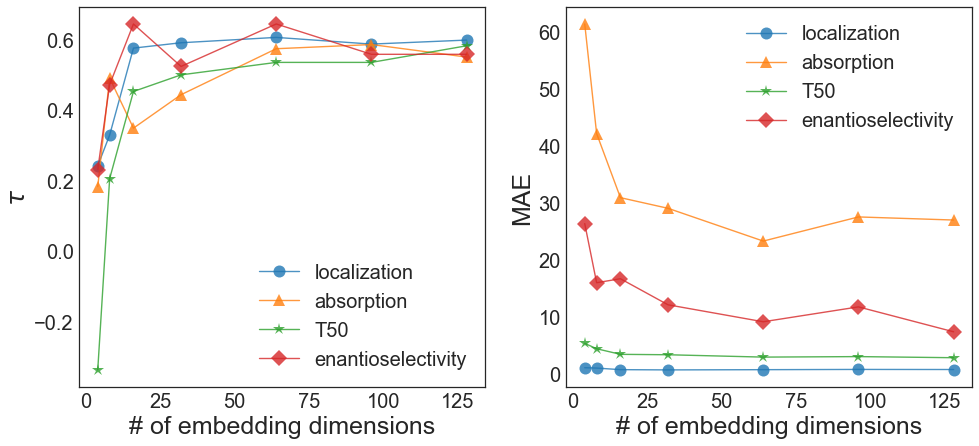

In [15]:
labels = ['localization', 'absorption', 'T50', 'enantioselectivity']
markers = ['-o', '-^', '-*', '-D']

fig, axs = plt.subplots(1, 2, figsize=(16, 7))

for t, la, ma in zip(tasks, labels, markers):
    df_lim = res[res['task'] == t]
    df_lim = df_lim.sort_values('d')
    for i, metric in enumerate(['kendalltau', 'mae']):
        _ = axs[i].plot(df_lim['d'], df_lim[metric], ma, label=la, alpha=0.8, ms=12)
        _ = axs[i].legend()
        _ = axs[i].set_xlabel('# of embedding dimensions')

_ = axs[0].set_ylabel(r'$\tau$')
_ = axs[1].set_ylabel('MAE')

# _ = fig.savefig('revised_paper_figs/vary_d_curve.pdf', bbox_inches='tight')